# Projeto 1

O roteiro é mais ou menos esse:

    Sugestão de Roteiro Prático

    Realize uma análise exploratória dos dados (EDA).​

    Padronize os dados com StandardScaler.​

    Aplique PCA para reduzir a dimensionalidade e visualize os dados em 2D ou 3D.​

    Considere binarizar a variável quality para transformar o problema em uma classificação binária.​

    Treine modelos como Random Forest, SVM e XGBoost.​

    Avalie os modelos utilizando métricas apropriadas (acurácia, precisão, recall, F1-score).​

    Ajuste os hiperparâmetros utilizando técnicas como GridSearchCV.​

    Documente os resultados e conclusões.

## Imports

In [7]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

## Análise dos Dados

## Leitura dos dados e gráficos iniciais

Primeiras linhas do dataset:
   Followers  Following Following/Followers  Posts Posts/Followers  Bio  \
0          2       2757              1378.5      0               0    N   
1          2        505               252.5      0               0    N   
2       6786       1782         0.262599469   1589     6051.040404  yes   
3         21       1281                  61      0               0    N   
4        585       1682         2.875213675   2663     926.1920333  yes   

  Profile Picture External Link  Mutual Friends Threads Labels  
0               N             N               0       N    Bot  
1             Yes             N               0       N   Scam  
2               N           Yes              10       N   Real  
3             Yes             N               0       N    Bot  
4               N             N              12     Yes   Real  

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 column

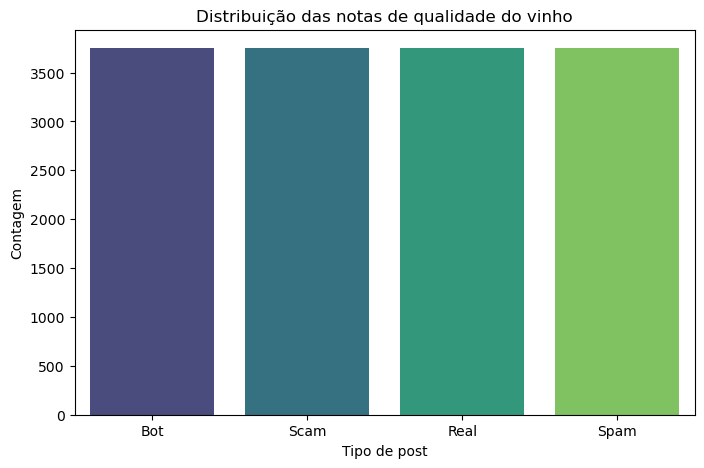

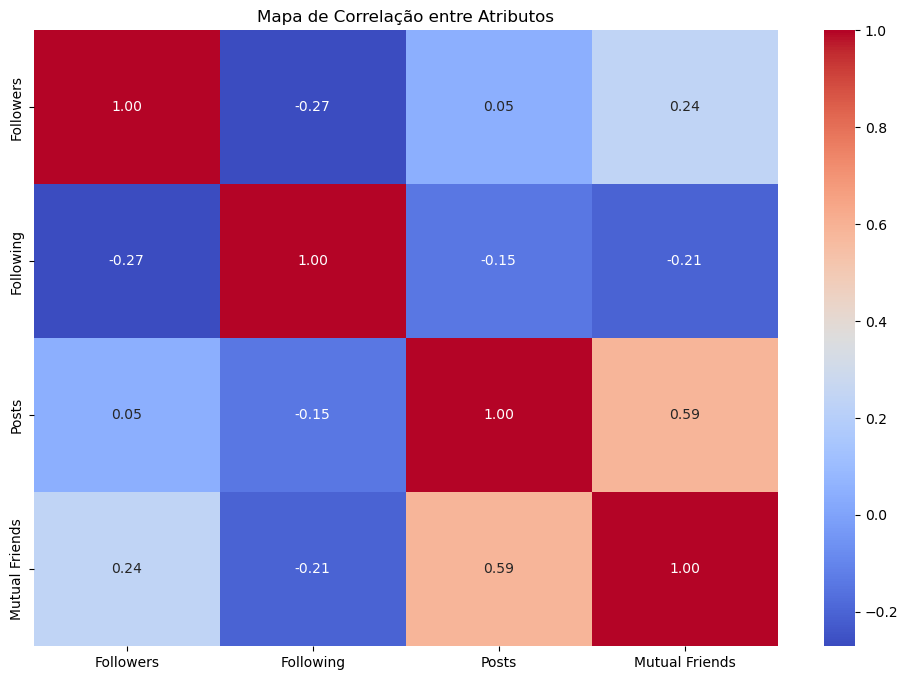

In [8]:
# 1. Definir o caminho para o arquivo CSV
path = "C:/Users/gabri/Downloads/LIMFADD.csv"

# 2. Carregar o dataset
# Substitua o caminho abaixo pelo caminho local do seu arquivo
df = pd.read_csv(path)

# Remove a coluna "Id" se existir
if "Id" in df.columns:
    df = df.drop(columns=["Id"])

# 3. Visualizar as primeiras linhas
print("Primeiras linhas do dataset:")
print(df.head())

# 4. Informações gerais sobre o dataset
print("\nInformações do dataset:")
print(df.info())

# 5. Estatísticas descritivas
print("\nEstatísticas descritivas:")
print(df.describe())

# 6. Verificar valores nulos
print("\nValores nulos por coluna:")
print(df.isnull().sum())

# 7. Distribuição da variável alvo (qualidade)
plt.figure(figsize=(8, 5))
sns.countplot(x='Labels', data=df, palette='viridis')
plt.title('Distribuição das notas de qualidade do vinho')
plt.xlabel('Tipo de post')
plt.ylabel('Contagem')
plt.show()

# 8. Mapa de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Correlação entre Atributos')
plt.show()


## Análise básica de variáveis (tipos, estatísticas e desbalanceamento)

### 1. Tipos das Variáveis:

In [9]:
print("Tipos de Variáveis:\n")
print(df.dtypes)

Tipos de Variáveis:

Followers               int64
Following               int64
Following/Followers    object
Posts                   int64
Posts/Followers        object
Bio                    object
Profile Picture        object
External Link          object
Mutual Friends          int64
Threads                object
Labels                 object
dtype: object


É possível verificar que todas as variáveis são valores do tipo *float*, e apenas a qualidade é do tipo *int*. Isto significa que não há a necessidade de um pré-processamento para converter variáveis categóricas.

### 2. Estatísticas descritivas

In [10]:
print("Estatísticas Descritivas:\n")
print(df.describe())

Estatísticas Descritivas:

           Followers     Following         Posts  Mutual Friends
count   15000.000000  15000.000000  15000.000000    15000.000000
mean    23397.378933   1385.350000    427.830200        3.011733
std     41920.419061   1600.823163    678.889037        4.203313
min         0.000000      0.000000      0.000000        0.000000
25%         6.000000    369.000000      1.000000        0.000000
50%        48.000000    725.500000      4.000000        0.000000
75%     19535.250000   1747.000000    578.250000        6.000000
max    163000.000000   6692.000000   2669.000000       15.000000


Podemos notar que o maior desvio padrão (~$32.8$) pertence à variável $\texttt{total sulfur dioxide}$. Além disso, a variável $\texttt{volatile acidity}$ varia de $0.12$ a $1.58$, o que pode indicar um possível outlier, ou uma ampla variação dos vinhos.

### 3. Verificar desbalanceamento da variável target (quality)

In [12]:
print("Distribuição da variável 'quality':\n")
print(df["Labels"].value_counts().sort_index())

Distribuição da variável 'quality':

Labels
Bot     3750
Real    3750
Scam    3750
Spam    3750
Name: count, dtype: int64


Nota-se que as classificações $3$, $4$ e $8$ possuem uma representação bem inferior em relação as demais, o que indica um certo desbalanceamento de classe. Tendo isso em mente, optamos por agrupar classificar como **ruim** um vinho que tenha qualidade $3-5$, **médio** um que tenha qualidade **6**, e **bom** um que tenha qualidade $7-8$.

In [14]:
# Criar nova coluna com rótulo de qualidade: 0 = ruim, 1 = médio, 2 = bom
def classificar_qualidade(label):
    if label == "Real":
        return 0  # ruim
    elif label == "Spam":
        return 1  # médio
    elif label == "Scam":
        return 2
    else:
        return 3  # bom

df["acc_type"] = df["Labels"].apply(classificar_qualidade)

# Verificar distribuição das novas classes
print("Distribuição das classes (0=Real, 1=Spam, 2=Scam, 3=Bot):")
print(df["acc_type"].value_counts().sort_index())

Distribuição das classes (0=Real, 1=Spam, 2=Scam, 3=Bot):
acc_type
0    3750
1    3750
2    3750
3    3750
Name: count, dtype: int64


### Aplico PCA para visualizar os dados e buscar por outliers

In [15]:
# Identificar colunas numéricas (excluindo a target)
feature_cols = df.drop(columns=["Labels", "acc_type"]).columns

# Normalização das features
feature_cols = df.drop(columns=["Labels", "acc_type"]).columns
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df_scaled[feature_cols])

# PCA para redução para 2 dimensões
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_scaled[feature_cols])

# DataFrame com os componentes principais
df_pca = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
df_pca['acc_type'] = df_scaled['acc_type']

# Gráfico
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='acc_type', palette="Set1")
plt.title("Visualização dos dados após PCA (2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title='Classes (0=Real, 1=Spam, 2=Scam, 3=Bot)')
plt.grid(True)
plt.show()

ValueError: could not convert string to float: '#DIV/0!'